In [1]:
####
## Celso Antonio Uliana Junior
## July 2 2020
####

import pandas as pd

#####
## Consuming and shaping the data to analysis
## Covid-19 numbers in Brazil by date
## Isolation percentage in Brazil by date
#####

data_raw_covid = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/covidBrasil.csv", sep = ";", decimal = ",")
data_raw_isolation = pd.read_csv("C:/Users/PCDOMILHAO/Documents/GitHub/trab-siad/scripts/Jupyter-Notebook/dados/isolamento.csv", sep = ";", decimal = ",")
data_covid = data_raw_covid['Data'].values.copy()
data_covid = data_raw_covid.dropna().set_index("Data")
data_isolation = data_raw_isolation['Data'].values.copy()
data_isolation = data_raw_isolation.dropna().set_index("Data")

####
## Shaping a central pandas dataFrame for all our ML needs
####

data = data_covid
data['Taxa'] = data_isolation['Taxa'].values.copy()


In [2]:
from sklearn.preprocessing import MinMaxScaler

####
## normalizing values for both covid and isolation percentage 
## between range [0,1] using sklearn MinMaxScaler
####

covid_norm = data_covid["Casos"].values.copy()
covid_norm.shape = (len(covid_norm), 1)

isolation_norm = data_isolation["Taxa"].values.copy()
isolation_norm.shape = (len(isolation_norm), 1)

####
## Shaping the central dataFrame with normalized values
####
min_max_scaler = MinMaxScaler()

covid_norm = min_max_scaler.fit_transform(covid_norm)
isolation_norm = min_max_scaler.fit_transform(isolation_norm)

data["CasosNormalizados"] = covid_norm
data["TaxaNormalizadas"] = isolation_norm
data.head(20)

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas
Data,,,,
26/2/20,1,24.7,0.000018,0.000000
27/2/20,0,27.5,0.000000,0.074667
28/2/20,0,26.6,0.000000,0.050667
29/2/20,0,31.4,0.000000,0.178667
1/3/20,1,42,0.000018,0.461333
2/3/20,0,27.7,0.000000,0.080000
3/3/20,0,29,0.000000,0.114667
4/3/20,0,30.2,0.000000,0.146667
5/3/20,1,29.7,0.000018,0.133333


In [3]:
####
## Sliding window
####
df = pd.DataFrame()
window_size = 6
for i in range(0, window_size + 1):
    df['E{}'.format(i)] = data['CasosNormalizados'].shift(-i)
    if(i == window_size):
        for j in range(0, window_size + 1):
             df['E{}'.format(j + i + 1)] = data['TaxaNormalizadas'].shift(-j)
        df['E{}'.format(window_size * 2 + 2)] = data['CasosNormalizados'].shift(-window_size)
df = df.iloc[: -window_size]
print(df)

               E0        E1        E2        E3        E4        E5        E6  \
Data                                                                            
26/2/20  0.000018  0.000000  0.000000  0.000000  0.000018  0.000000  0.000000   
27/2/20  0.000000  0.000000  0.000000  0.000018  0.000000  0.000000  0.000000   
28/2/20  0.000000  0.000000  0.000018  0.000000  0.000000  0.000000  0.000018   
29/2/20  0.000000  0.000018  0.000000  0.000000  0.000000  0.000018  0.000091   
1/3/20   0.000018  0.000000  0.000000  0.000000  0.000018  0.000091  0.000091   
...           ...       ...       ...       ...       ...       ...       ...   
11/6/20  0.600920  0.555257  0.474375  0.396268  0.312392  0.376970  0.637527   
12/6/20  0.555257  0.474375  0.396268  0.312392  0.376970  0.637527  0.587683   
13/6/20  0.474375  0.396268  0.312392  0.376970  0.637527  0.587683  0.415640   
14/6/20  0.396268  0.312392  0.376970  0.637527  0.587683  0.415640  1.000000   
15/6/20  0.312392  0.376970 

In [4]:
####
## Manipulating the data to split into X(a window size of values)
## and target, or Y, the value X "produces"
####

arr = df.values

X = arr[:, : -1]
target = arr[:, -1]
#print(X)
#print(target)

In [5]:
####
## Config of the regressors and cross val k fold
####
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict

mlp = MLPRegressor(
    hidden_layer_sizes = (50,),  activation = 'relu', solver = 'adam', alpha = 0.001, batch_size = 'auto',
    learning_rate = 'constant', learning_rate_init = 0.01, power_t = 0.5, max_iter = 1000, shuffle = True,
    random_state = 9, tol = 0.0001, verbose = True, warm_start = False, momentum = 0.9, nesterovs_momentum = True,
    early_stopping = False, validation_fraction = 0.1, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08)
svr = SVR(kernel = 'linear', C = 0.25, epsilon = 0.01, verbose = True, max_iter = 1000)

full_predict_mlp = cross_val_predict(mlp, X, target, cv = 10)
full_predict_svr = cross_val_predict(svr, X, target, cv = 10)

Iteration 1, loss = 0.01693263
Iteration 2, loss = 0.00912534
Iteration 3, loss = 0.00439892
Iteration 4, loss = 0.00850785
Iteration 5, loss = 0.00536730
Iteration 6, loss = 0.00566027
Iteration 7, loss = 0.00458506
Iteration 8, loss = 0.00245914
Iteration 9, loss = 0.00277944
Iteration 10, loss = 0.00337228
Iteration 11, loss = 0.00265622
Iteration 12, loss = 0.00261995
Iteration 13, loss = 0.00314862
Iteration 14, loss = 0.00252921
Iteration 15, loss = 0.00195487
Iteration 16, loss = 0.00222865
Iteration 17, loss = 0.00210209
Iteration 18, loss = 0.00171048
Iteration 19, loss = 0.00203914
Iteration 20, loss = 0.00197698
Iteration 21, loss = 0.00160779
Iteration 22, loss = 0.00162800
Iteration 23, loss = 0.00159579
Iteration 24, loss = 0.00133304
Iteration 25, loss = 0.00131867
Iteration 26, loss = 0.00142707
Iteration 27, loss = 0.00129996
Iteration 28, loss = 0.00118085
Iteration 29, loss = 0.00121504
Iteration 30, loss = 0.00113676
Iteration 31, loss = 0.00099525
Iteration 32, los

Iteration 6, loss = 0.00374098
Iteration 7, loss = 0.00404163
Iteration 8, loss = 0.00339408
Iteration 9, loss = 0.00172947
Iteration 10, loss = 0.00167116
Iteration 11, loss = 0.00229915
Iteration 12, loss = 0.00185295
Iteration 13, loss = 0.00139421
Iteration 14, loss = 0.00182424
Iteration 15, loss = 0.00185233
Iteration 16, loss = 0.00127884
Iteration 17, loss = 0.00120812
Iteration 18, loss = 0.00144540
Iteration 19, loss = 0.00121997
Iteration 20, loss = 0.00092099
Iteration 21, loss = 0.00106408
Iteration 22, loss = 0.00115962
Iteration 23, loss = 0.00091853
Iteration 24, loss = 0.00080801
Iteration 25, loss = 0.00090716
Iteration 26, loss = 0.00082323
Iteration 27, loss = 0.00063885
Iteration 28, loss = 0.00066245
Iteration 29, loss = 0.00073516
Iteration 30, loss = 0.00064652
Iteration 31, loss = 0.00057755
Iteration 32, loss = 0.00063162
Iteration 33, loss = 0.00061642
Iteration 34, loss = 0.00051644
Iteration 35, loss = 0.00050627
Iteration 36, loss = 0.00054045
Iteration 37

In [6]:
####
## Printing some metrics of the regressors
####
print('Mean Squared Error in MLP: %s' %(metrics.mean_squared_error(target, full_predict_mlp)))
print('Mean Squared Error in SVR: %s' %(metrics.mean_squared_error(target, full_predict_svr)))

r_squared_mlp = metrics.r2_score(target, full_predict_mlp)
r_squared_svr = metrics.r2_score(target, full_predict_svr)

print('R² score in MLP: %s' %(r_squared_mlp))
print('R² score in SVR: %s' %(r_squared_svr))

adjusted_r_squared_mlp = 1 - (1 - r_squared_mlp) * (len(target) - 1) / (len(target) - X.shape[1] - 1)
adjusted_r_squared_svr = 1 - (1 - r_squared_svr) * (len(target) - 1) / (len(target) - X.shape[1] - 1)

print('adjusted R² score in MLP: %s' %(adjusted_r_squared_mlp))
print('adjusted R² score in SVR: %s' %(adjusted_r_squared_svr))

Mean Squared Error in MLP: 0.0024331421113141806
Mean Squared Error in SVR: 0.000614241050622446
R² score in MLP: 0.9435325879735833
R² score in SVR: 0.9857449335459066
adjusted R² score in MLP: 0.9352977570530642
adjusted R² score in SVR: 0.9836660696880181


In [7]:
####
## Filling lists with NaN so the len is the same across all lists 
## so that a graph can be generated
####
import numpy as np

values_to_add = list()
for i in range(0, window_size):
    values_to_add.append(float('NaN'))
    
full_predict_svr = np.insert(full_predict_svr, 0, values_to_add)
full_predict_svr.shape = (len(full_predict_svr), 1)
    
full_predict_mlp = np.insert(full_predict_mlp, 0, values_to_add)
full_predict_mlp.shape = (len(full_predict_mlp), 1)

print(full_predict_svr.shape)
print(full_predict_mlp.shape)

(117, 1)
(117, 1)


In [8]:
####
## Adding the data to plot 
####
data['Predict_mlp'] = full_predict_mlp
data['Predict_svr'] = full_predict_svr
data

,Casos,Taxa,CasosNormalizados,TaxaNormalizadas,Predict_mlp,Predict_svr
Data,,,,,,
26/2/20,1,24.7,0.000018,0.000000,NaN,NaN
27/2/20,0,27.5,0.000000,0.074667,NaN,NaN
28/2/20,0,26.6,0.000000,0.050667,NaN,NaN
29/2/20,0,31.4,0.000000,0.178667,NaN,NaN
1/3/20,1,42,0.000018,0.461333,NaN,NaN
...,...,...,...,...,...,...
17/6/20,34918,37.3,0.637527,0.336000,0.650432,0.604122
18/6/20,32188,38.5,0.587683,0.368000,0.670271,0.600747
19/6/20,22765,34.7,0.415640,0.266667,0.497580,0.459438


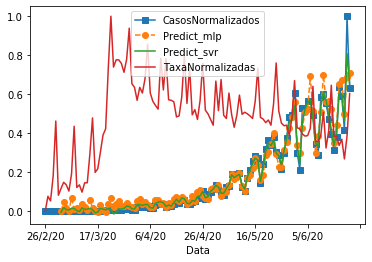

In [9]:
####
## Ploting the graph
####
import matplotlib.pyplot as plt
data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr', 'TaxaNormalizadas'], style=['-s', '--o'])
#data.plot(y=['CasosNormalizados', 'Predict_mlp', 'Predict_svr',], style=['-s', '--o'])
plt.show()

In [10]:
####
## Calculating Pearson correlation 
####
import numpy
from scipy.stats import pearsonr
arrTaxa = data['TaxaNormalizadas'].values.copy()
arrCasos = data['CasosNormalizados'].values.copy()
print(pearsonr(arrTaxa, arrCasos))

(-0.03892879028152567, 0.6768859337467233)
